In [32]:
import torch
import torch.nn.functional as F
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel

print("Loading GPT-2 model and tokenizer...")
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, attn_implementation="eager")
model.eval()
tokenizer.pad_token = tokenizer.eos_token
print("Setup complete.")

Loading GPT-2 model and tokenizer...
Setup complete.


In [ ]:
Attention Map

--- Running a full visual exploration on a sample sentence. ---


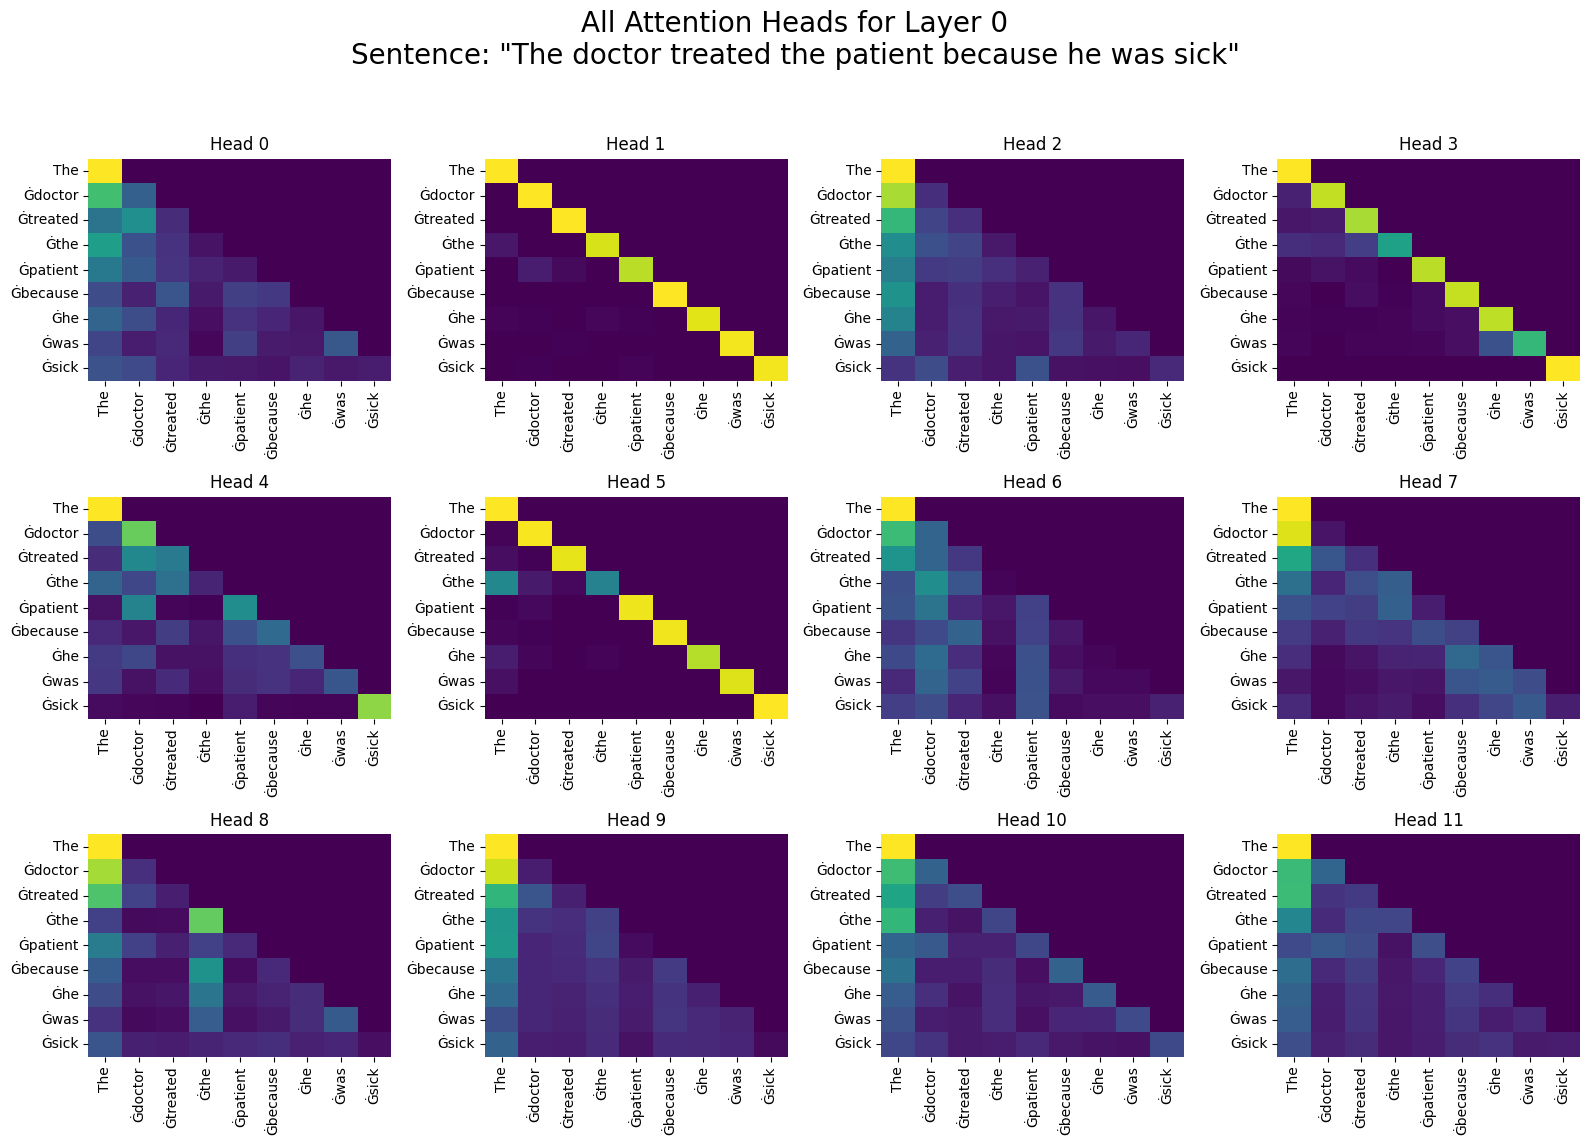

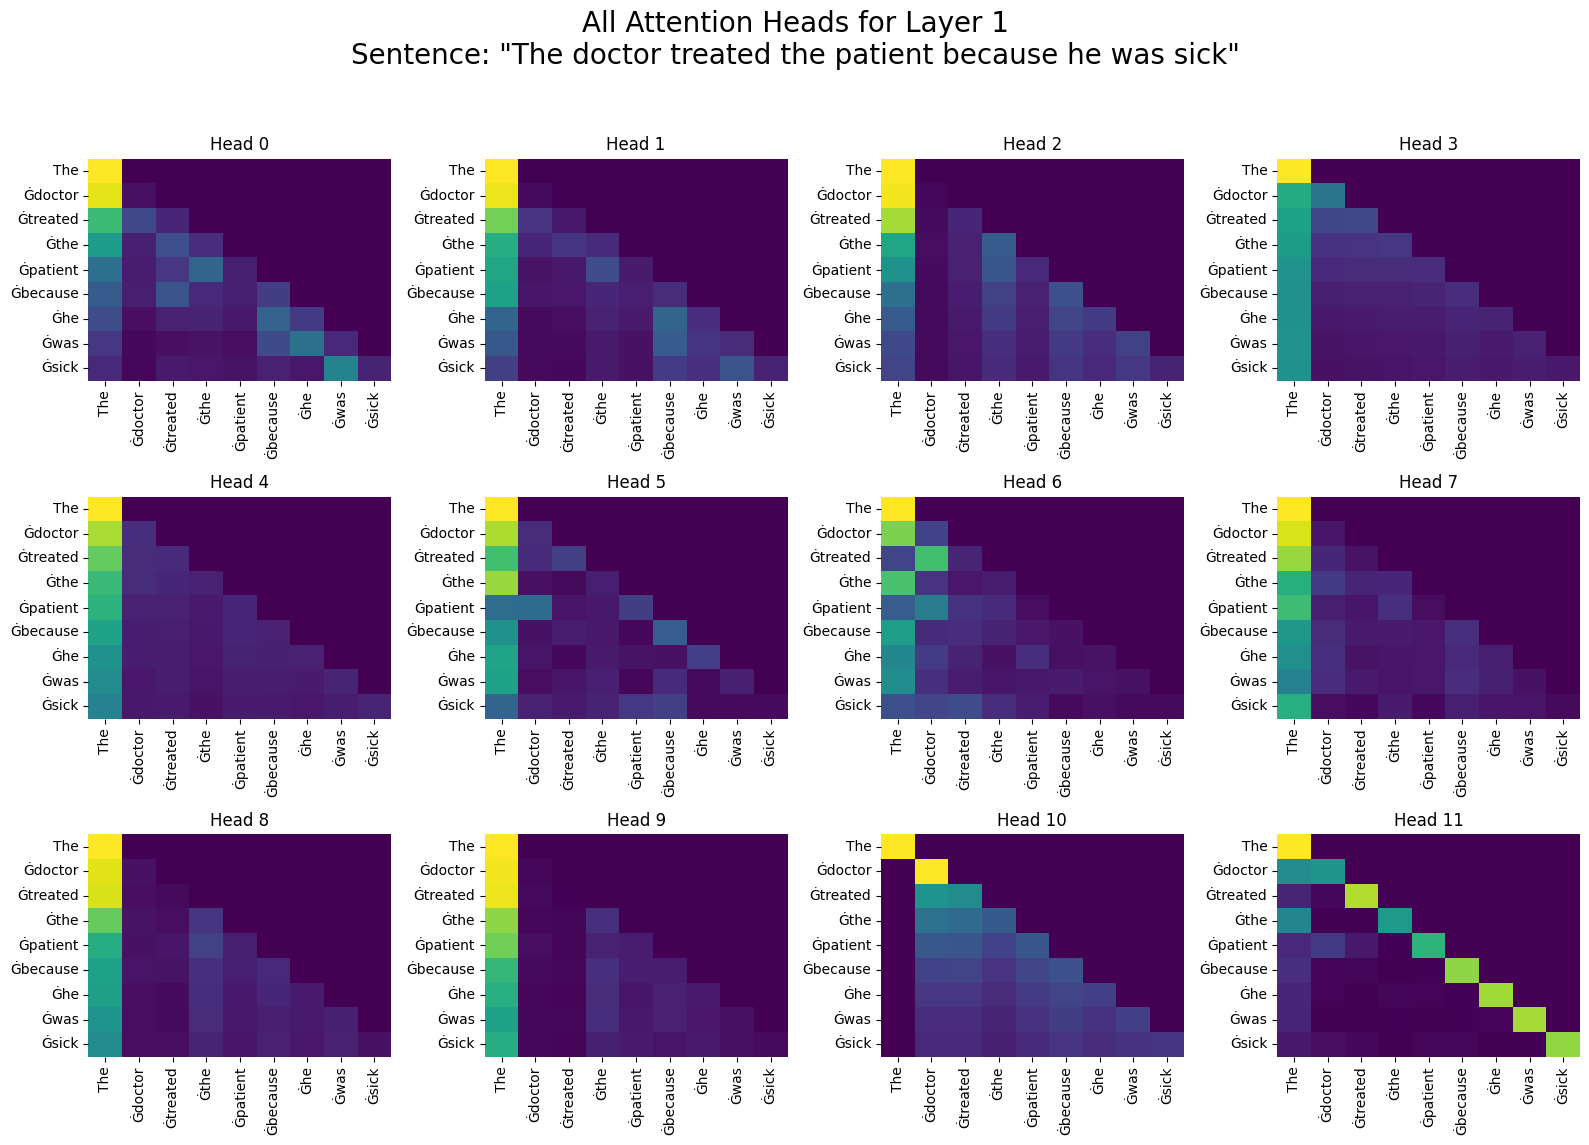

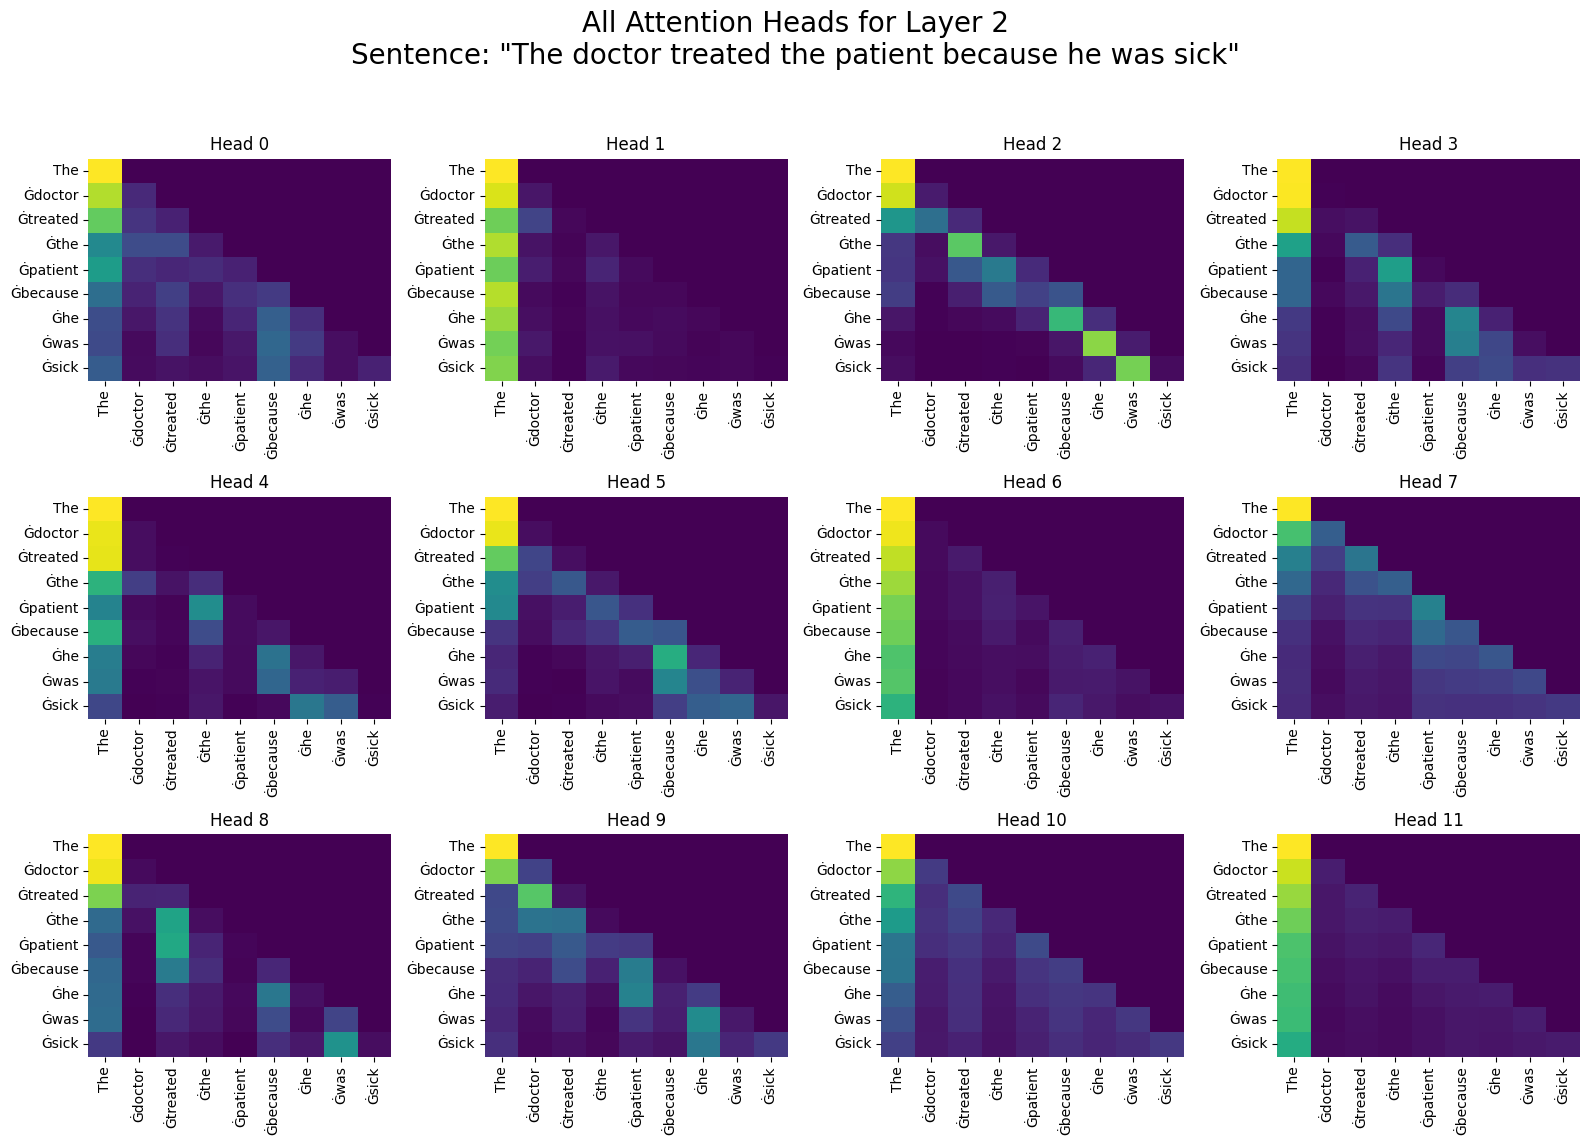

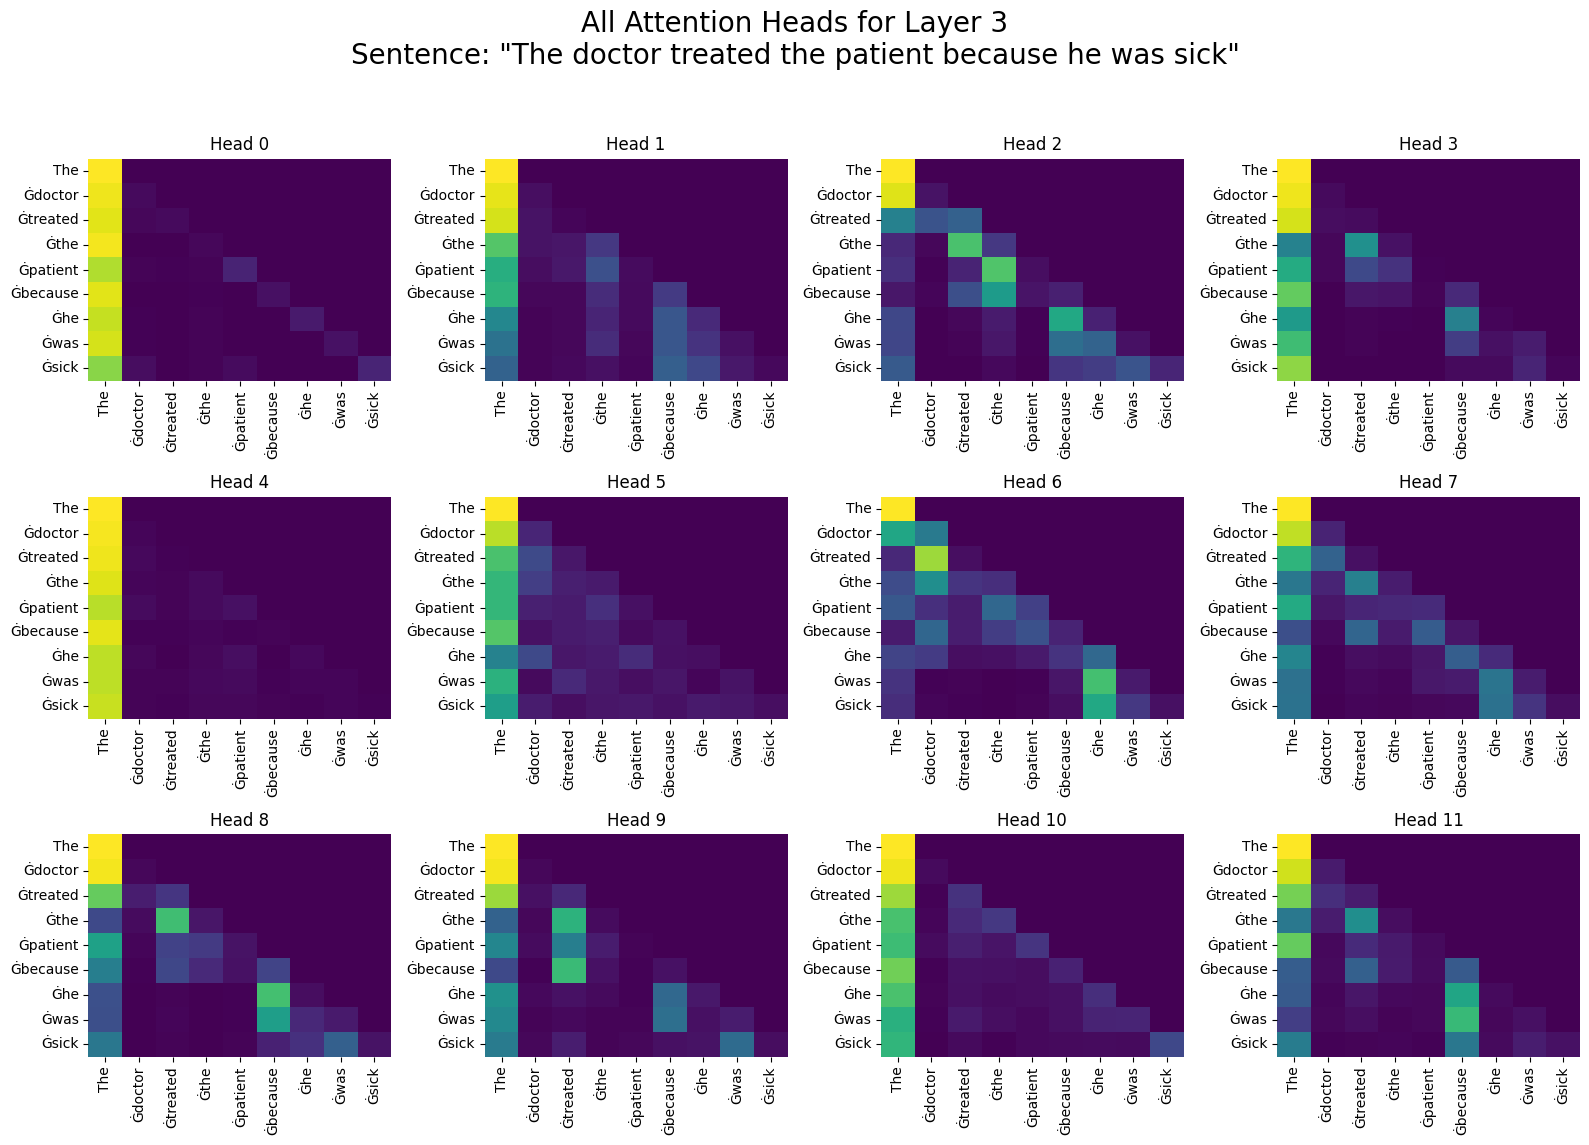

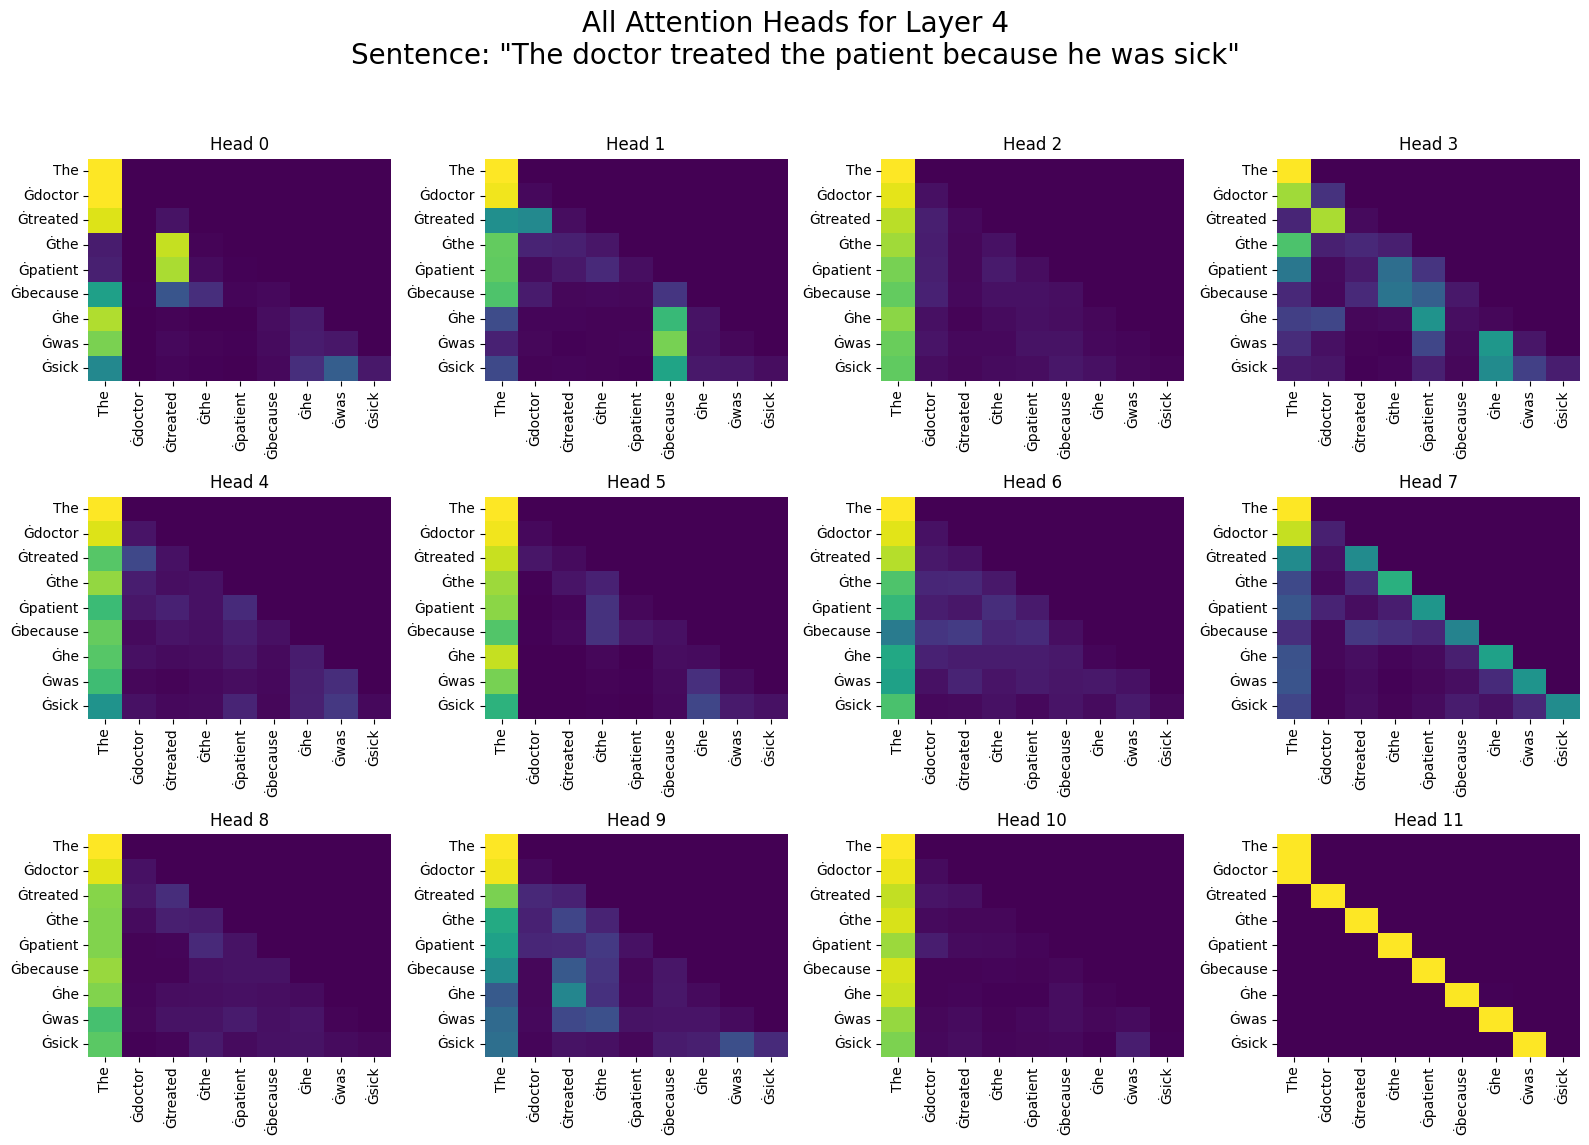

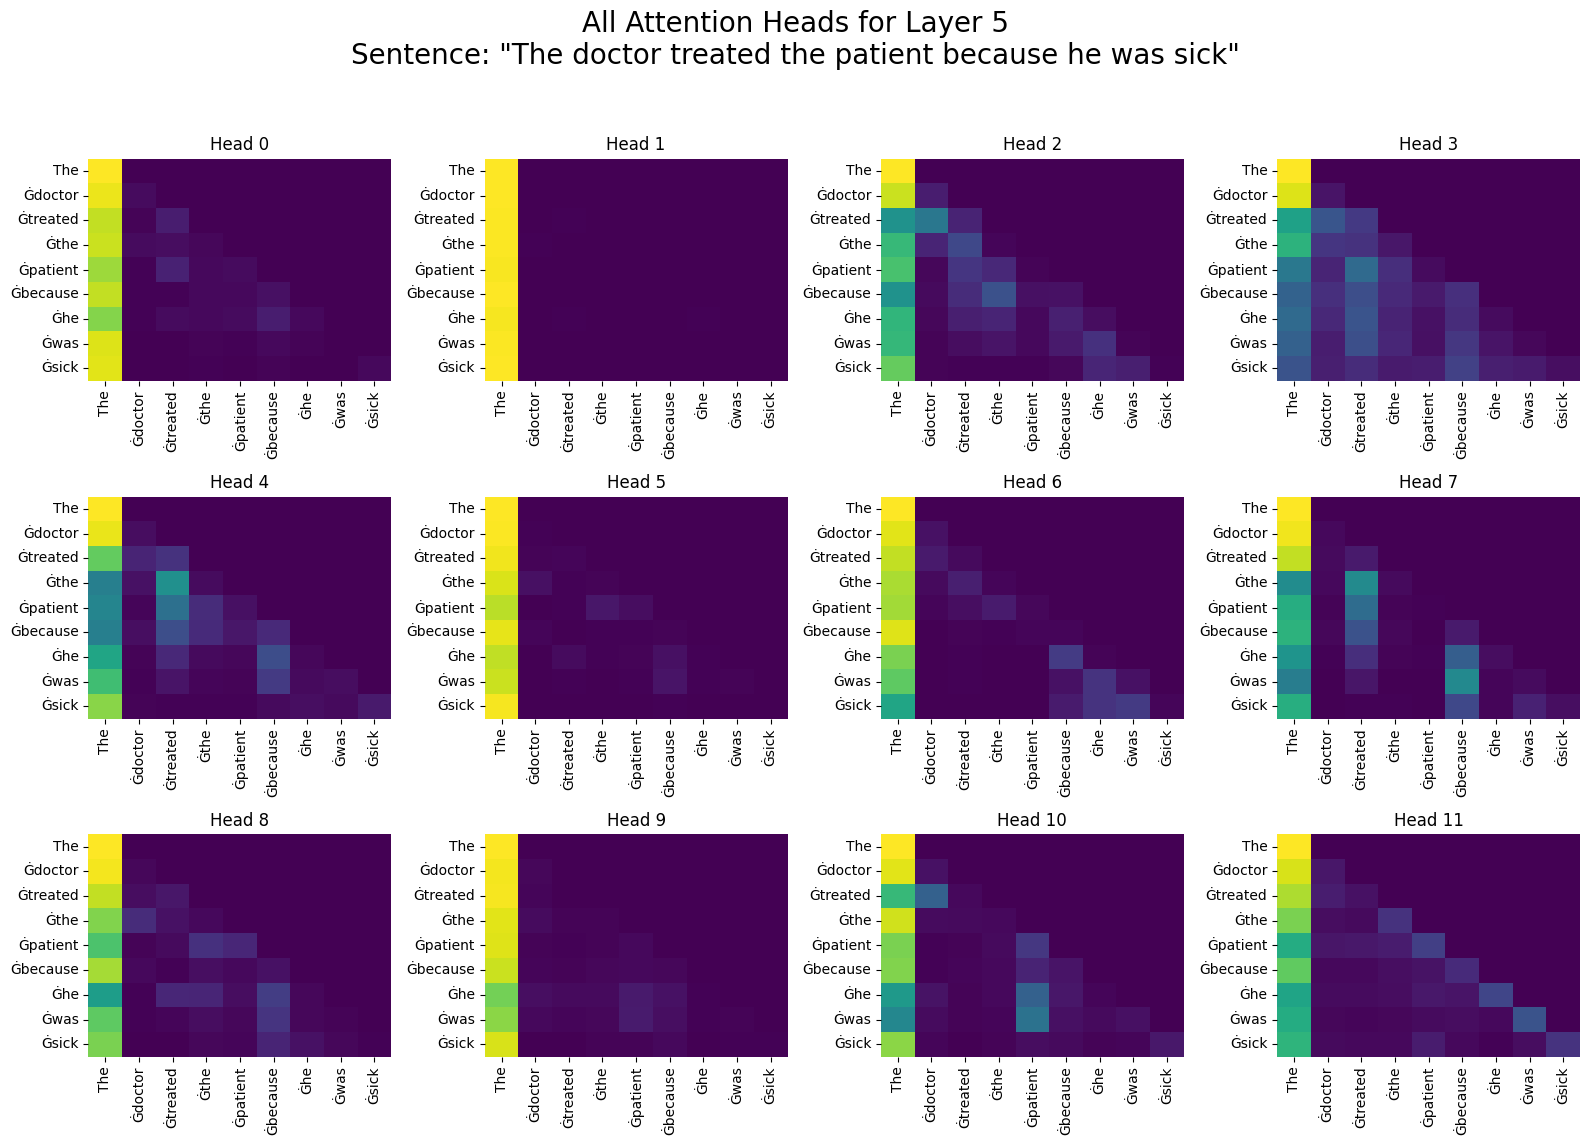

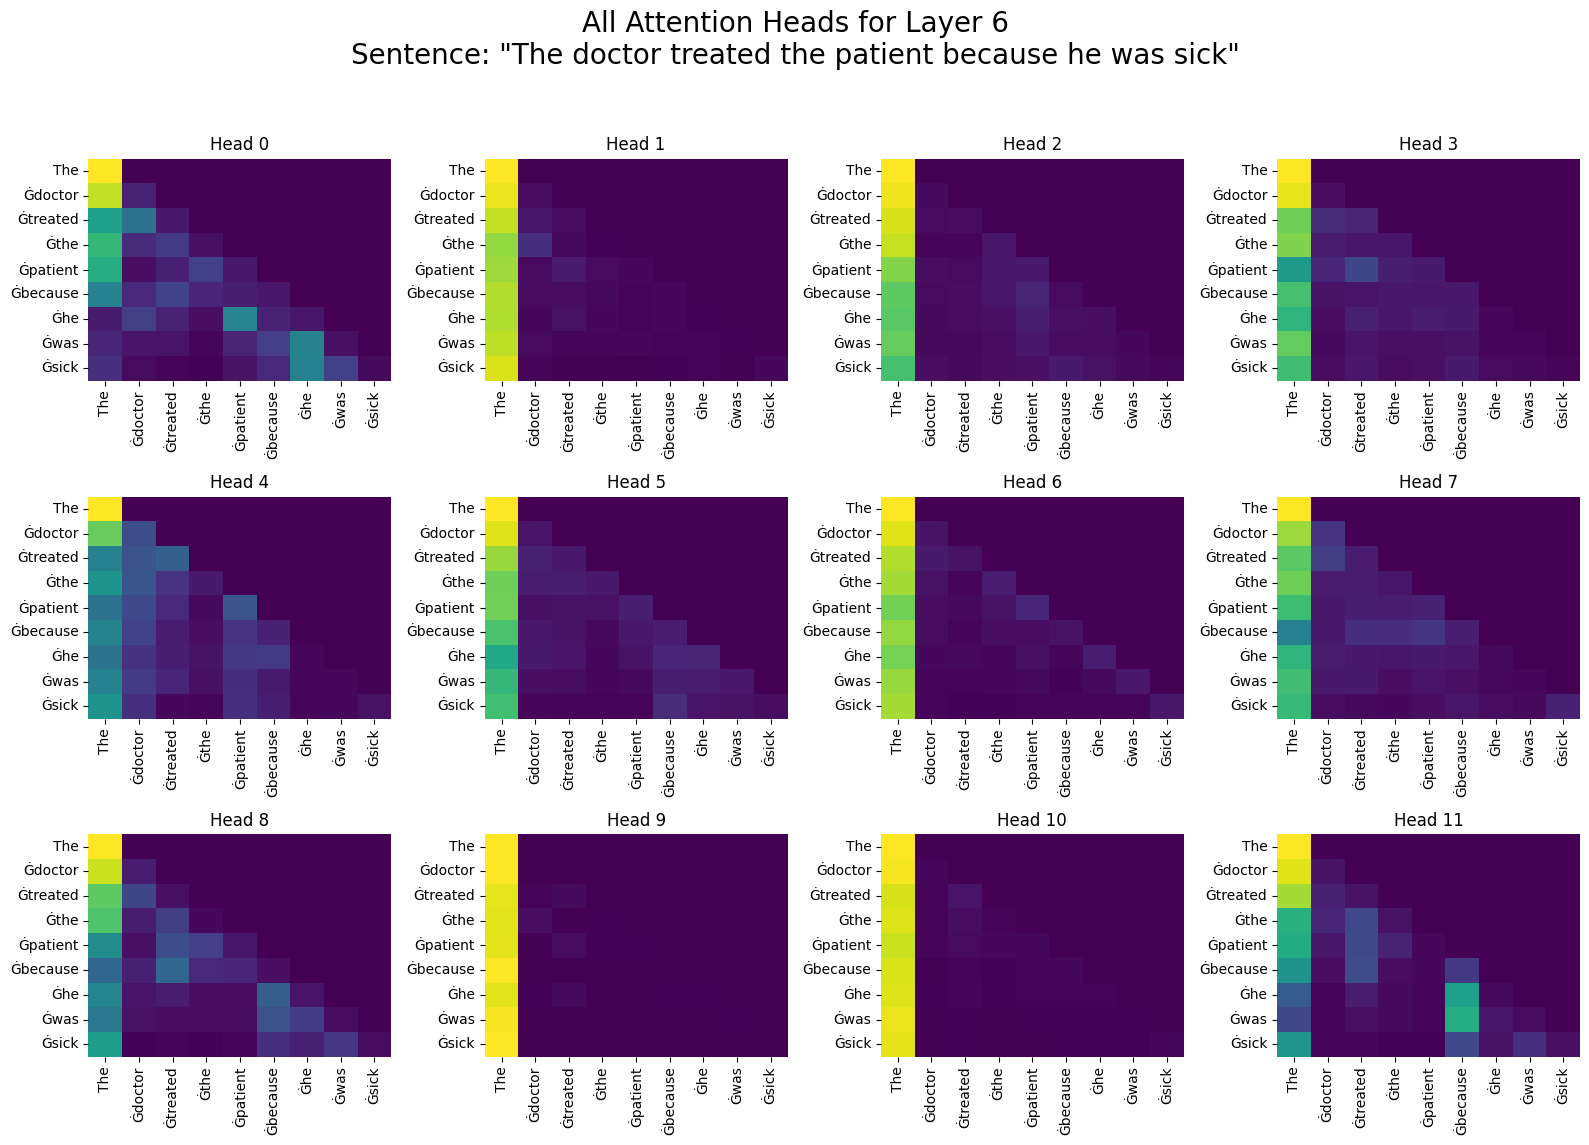

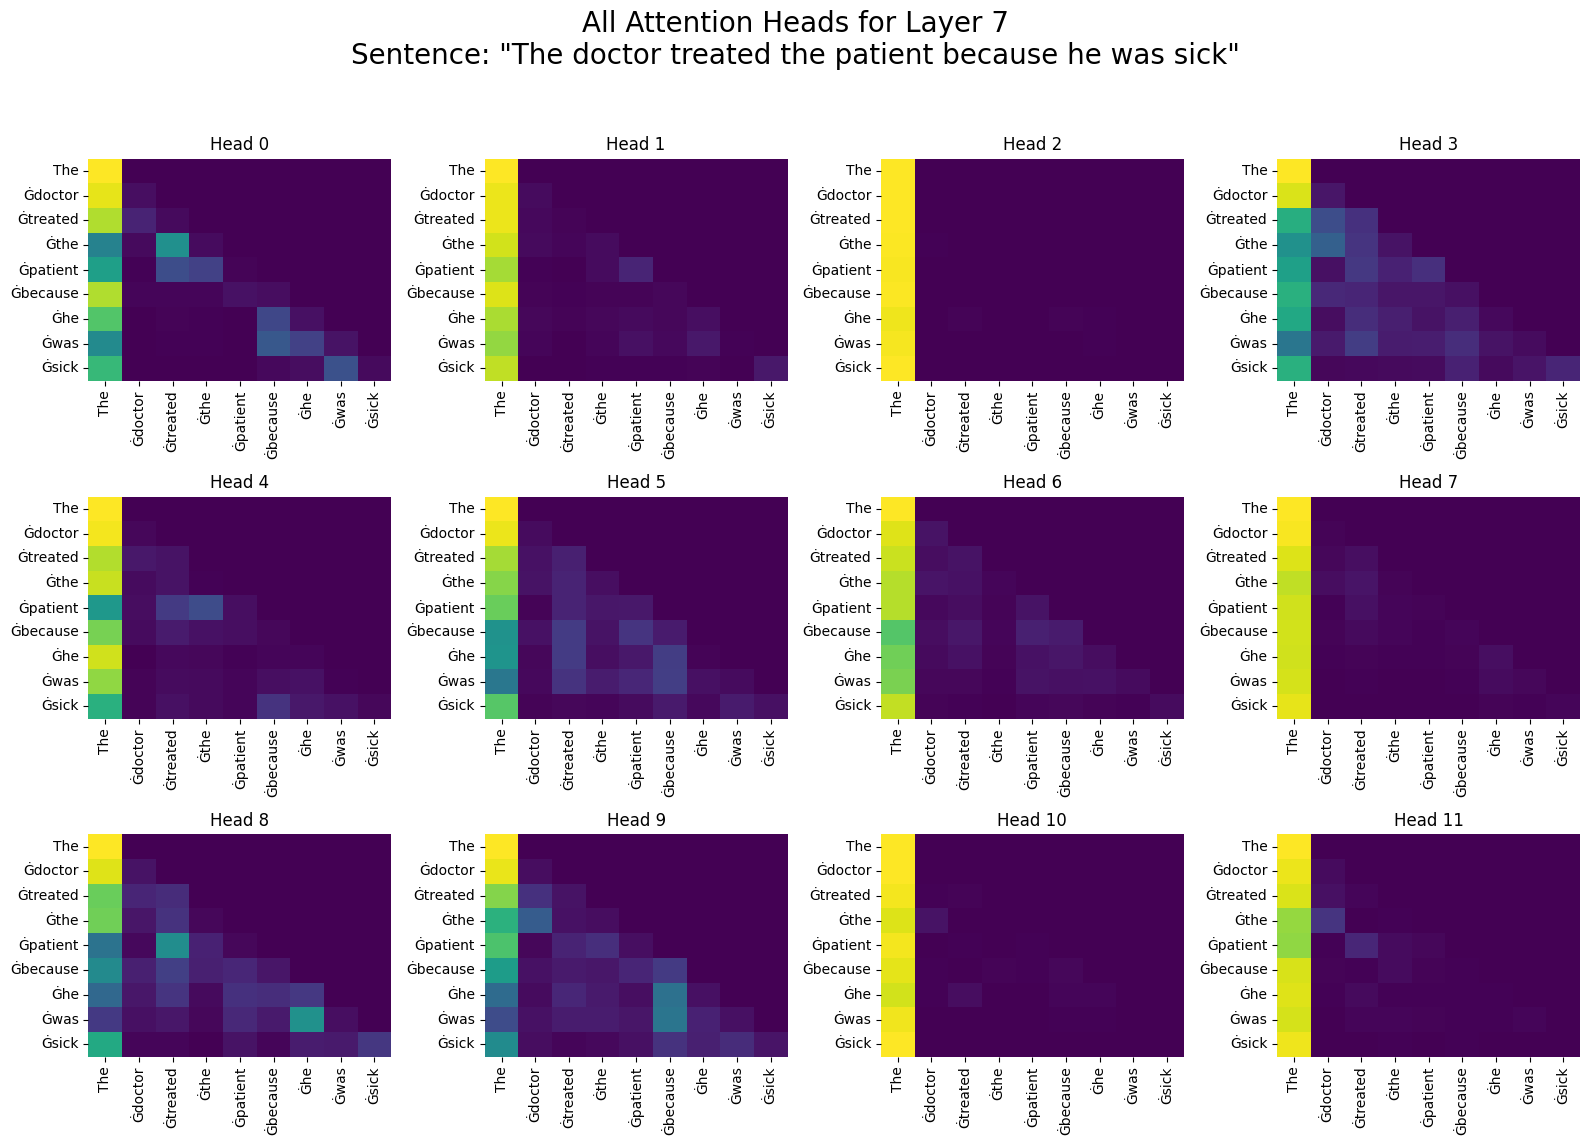

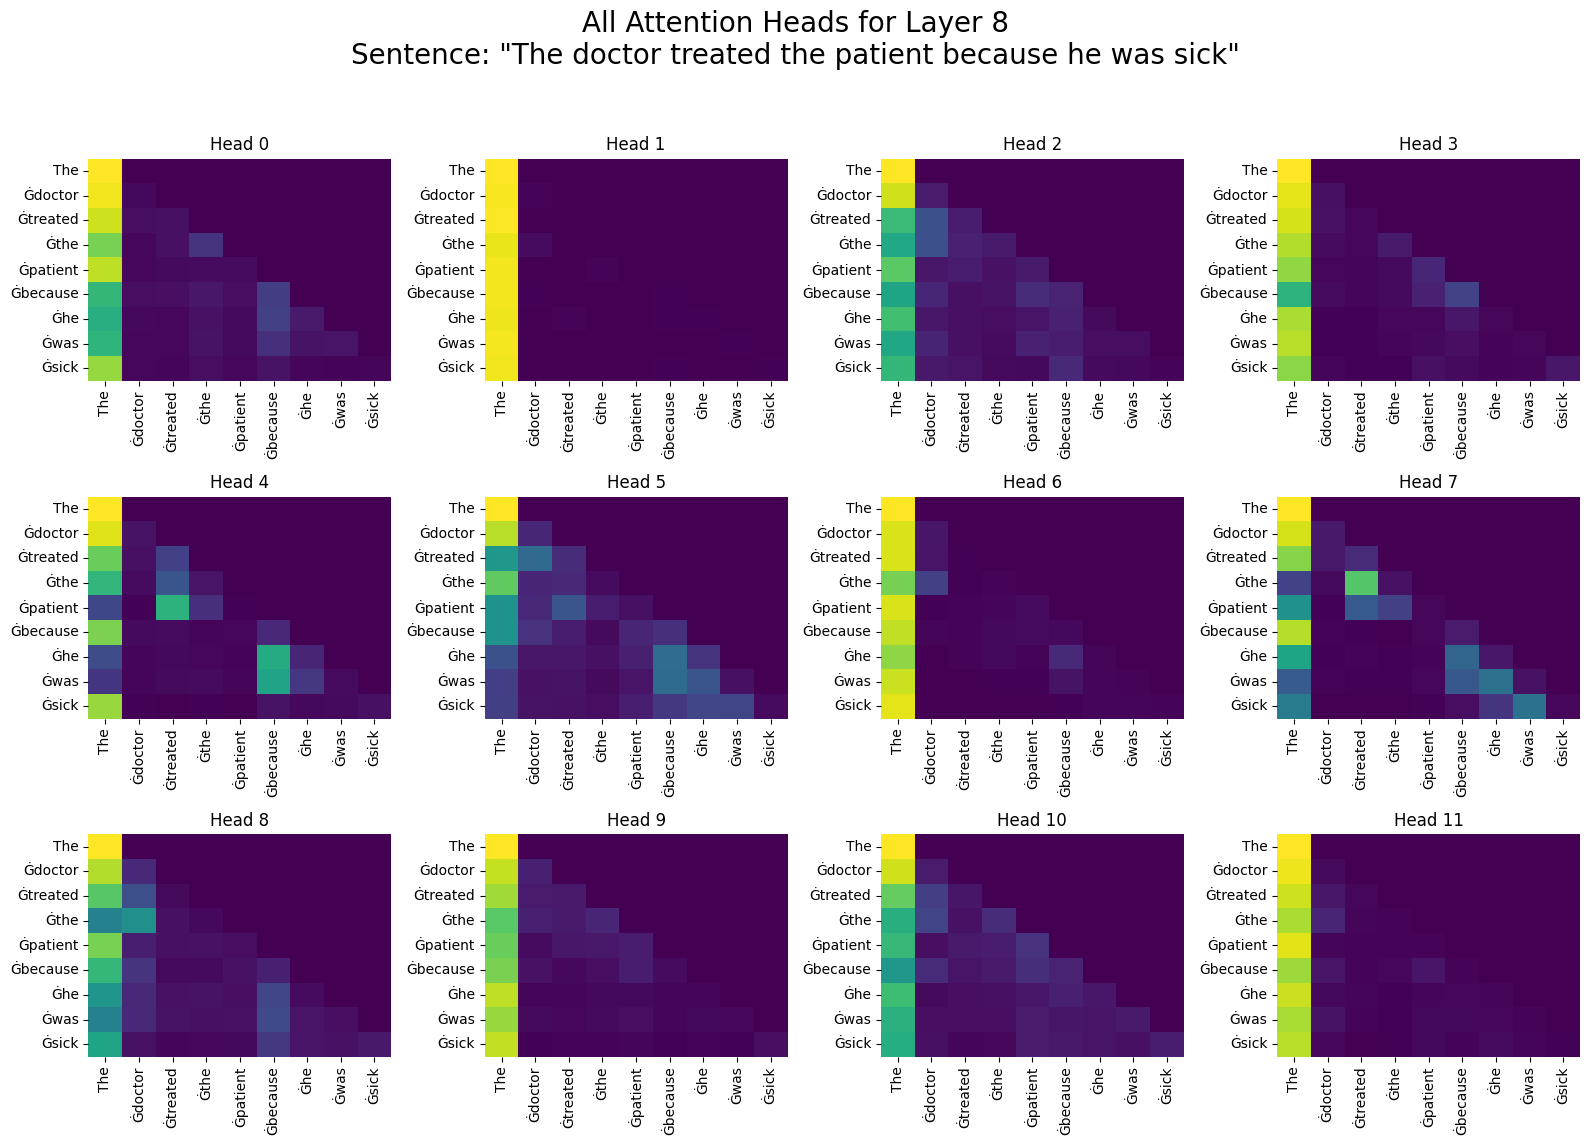

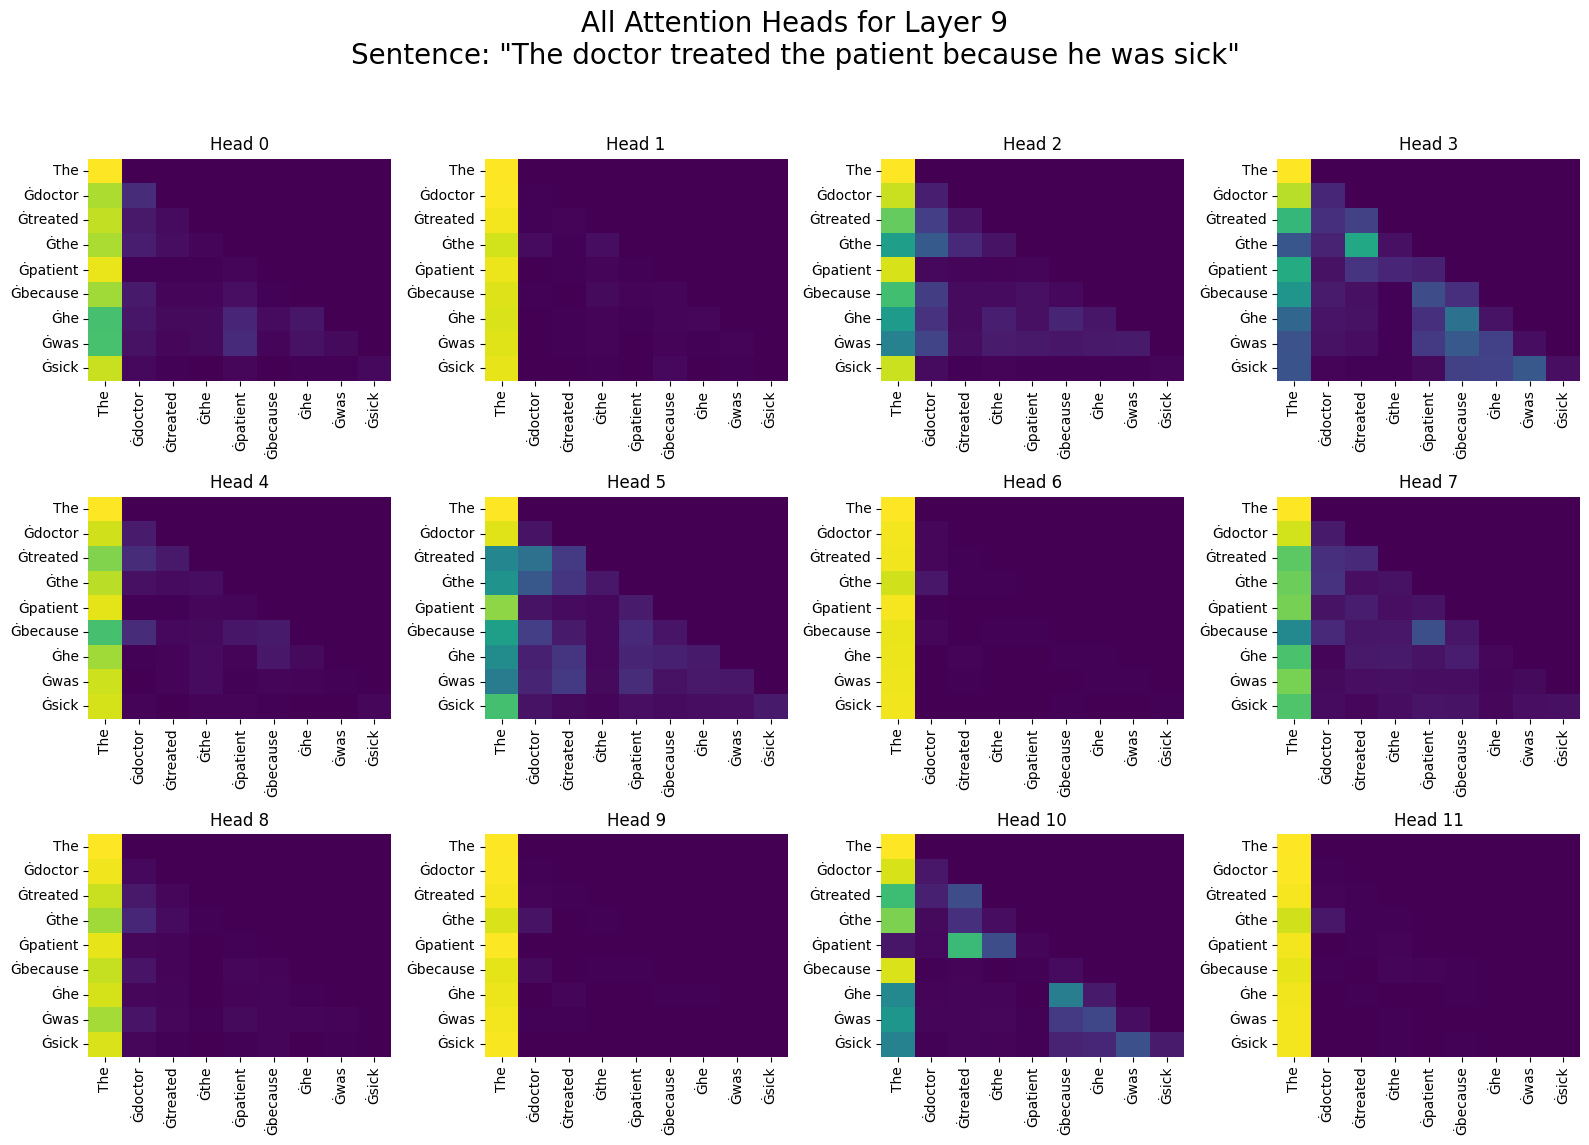

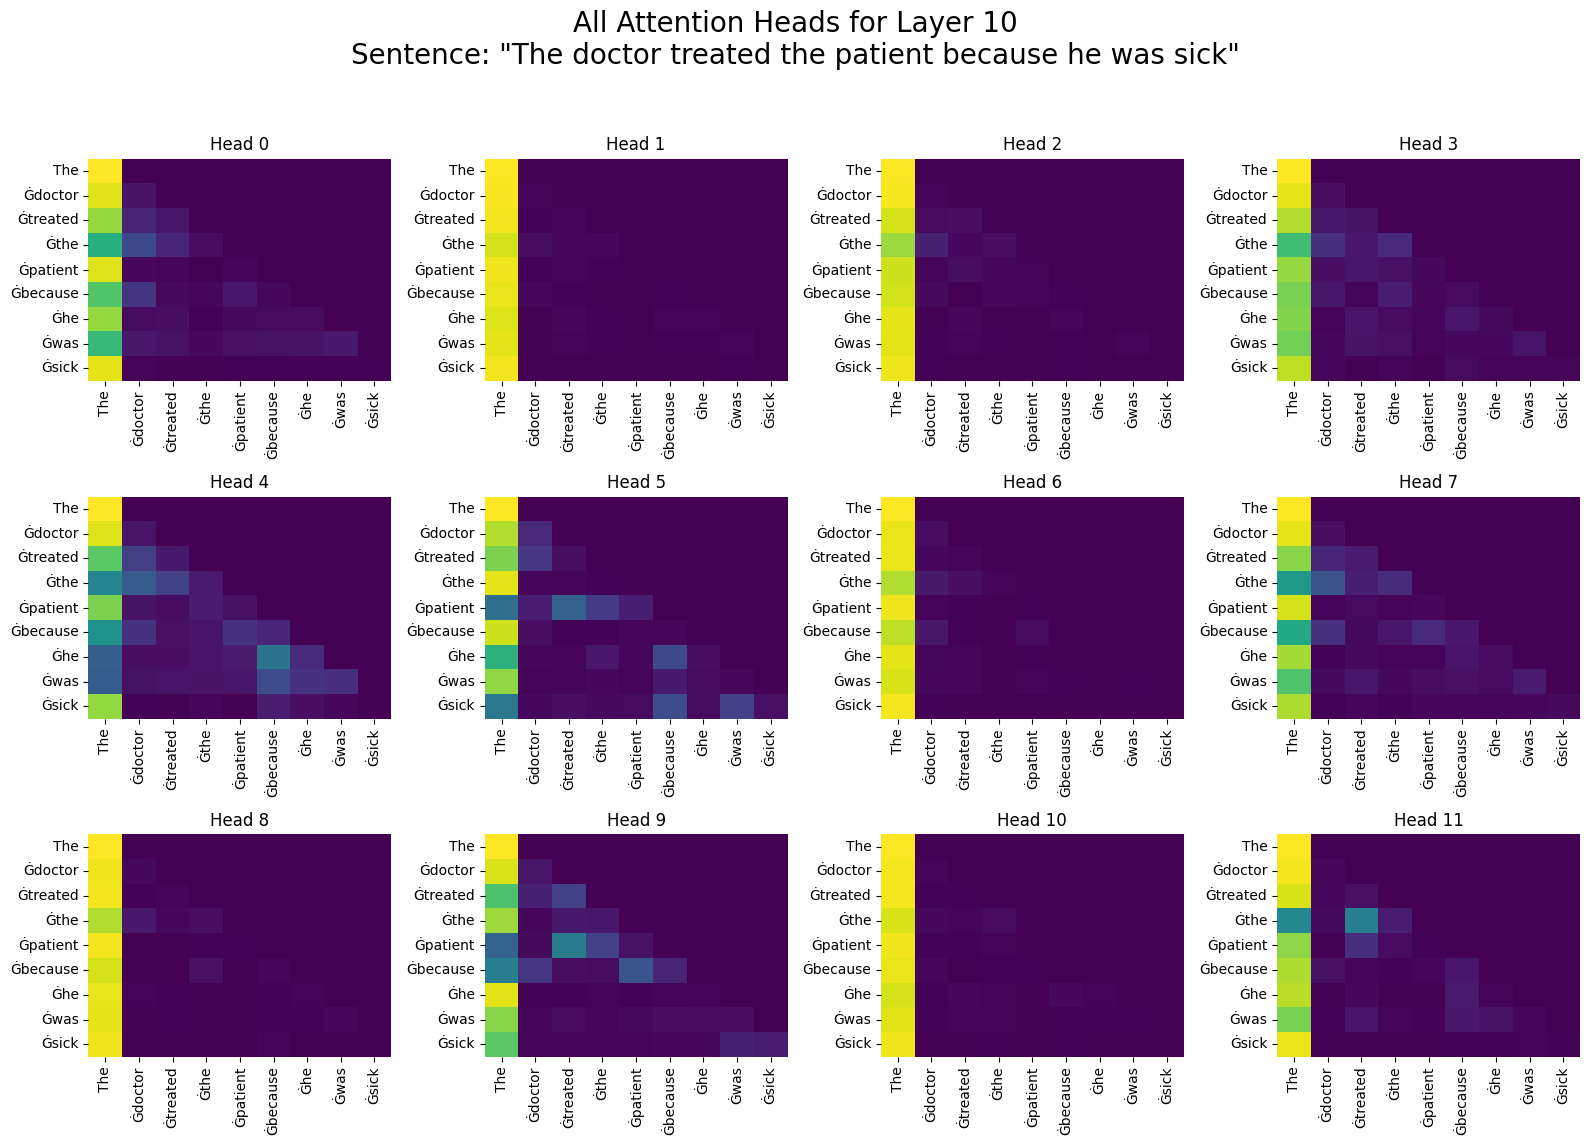

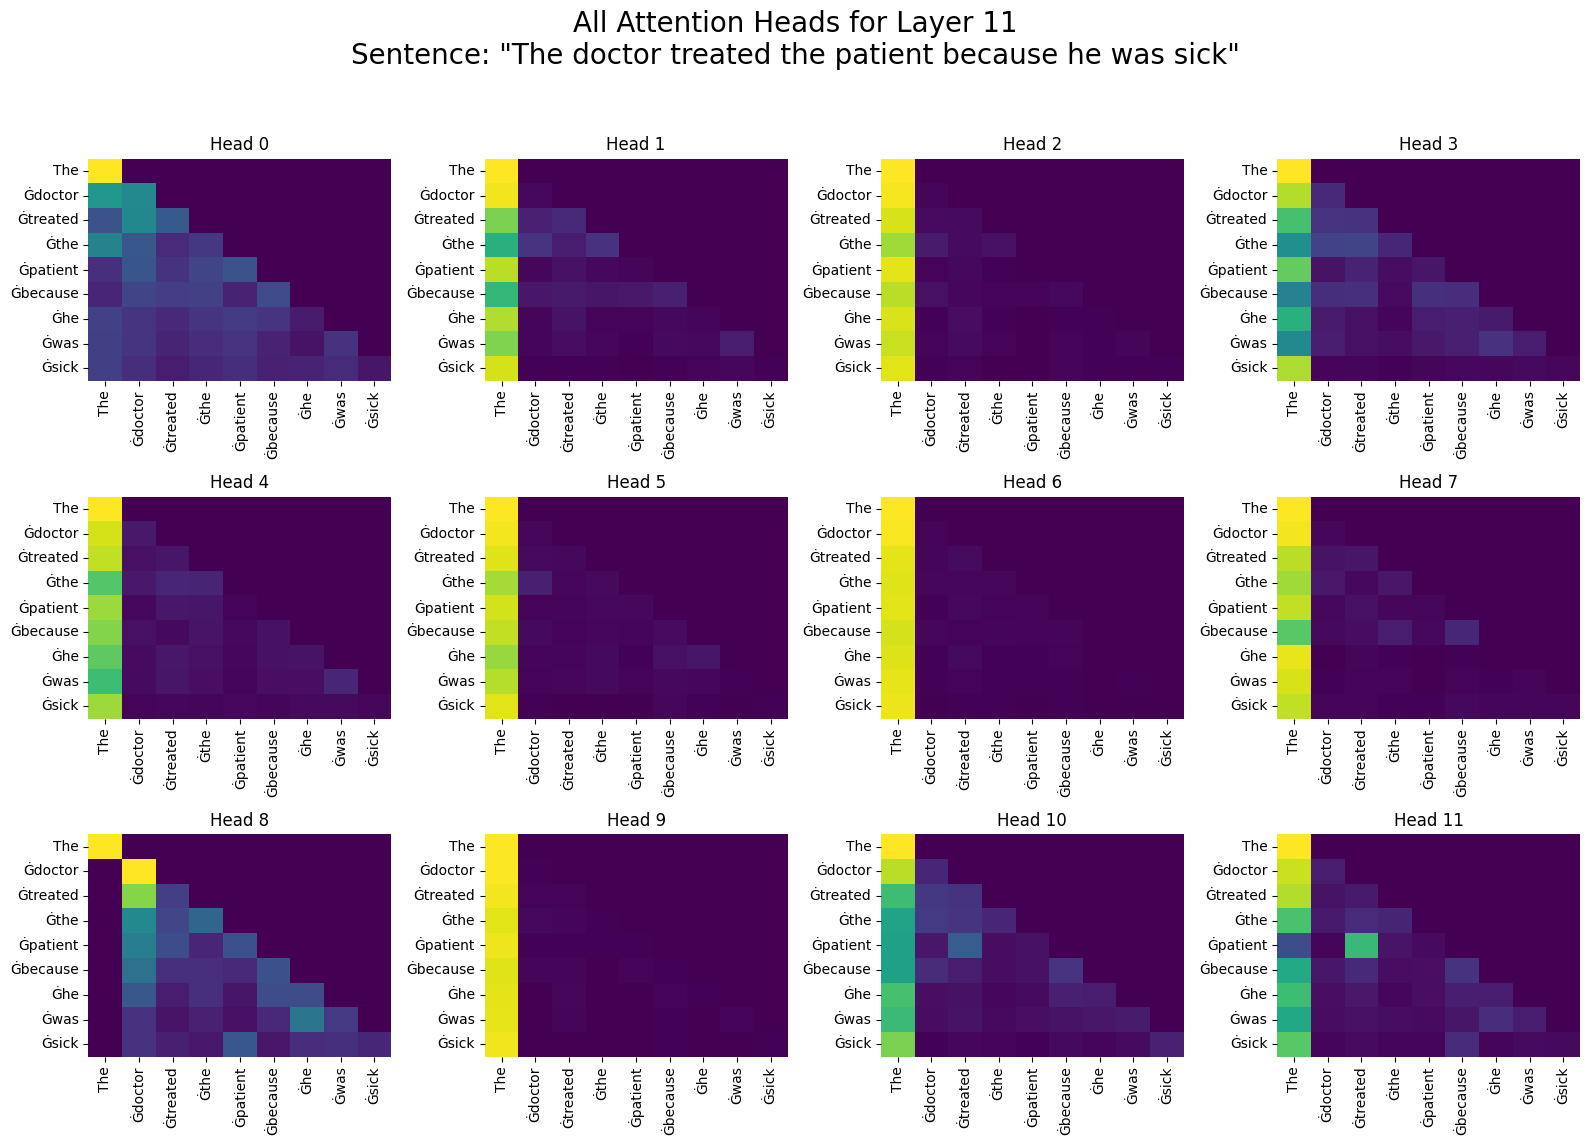

In [74]:
def visualize_all_layers_for_sentence(text):
    """Visualizes the attention patterns for all heads in every layer for a sentence."""
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    for layer_idx, attention in enumerate(outputs.attentions):
        attention = attention.squeeze(0).detach().numpy()
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.suptitle(f'All Attention Heads for Layer {layer_idx}\nSentence: "{text}"', fontsize=20)
        for head_idx in range(model.config.n_head):
            ax = axes[head_idx // 4, head_idx % 4]
            sns.heatmap(attention[head_idx], xticklabels=tokens, yticklabels=tokens, cmap='viridis', ax=ax, cbar=False)
            ax.set_title(f'Head {head_idx}')
            ax.tick_params(axis='x', rotation=90)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

if __name__ == "__main__":
    print("--- Running a full visual exploration on a sample sentence. ---")
    visualize_all_layers_for_sentence("The doctor treated the patient because he was sick")

Functions

In [38]:
def find_token_position(tokens, target_word):
    """Helper function to find token position, handling GPT-2's Ġ prefix."""
    try: return tokens.index('Ġ' + target_word)
    except ValueError:
        try: return tokens.index(target_word)
        except ValueError:
            for i, token in enumerate(tokens):
                if target_word.lower() in token.lower(): return i
            raise ValueError(f"Token '{target_word}' not found in {tokens}")

def analyze_semantic_role_attention(sentence, arg0, predicate, arg1):
    """Analyzes all 6 semantic role attention patterns for a single sentence."""
    inputs = tokenizer(sentence, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    try:
        arg0_pos, pred_pos, arg1_pos = (find_token_position(tokens, arg) for arg in (arg0, predicate, arg1))
    except ValueError:
        return None

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    results = {}
    for layer in range(model.config.n_layer):
        attention = outputs.attentions[layer].squeeze(0)
        layer_results = {}
        for head in range(model.config.n_head):
            p = {'pred_to_arg0': attention[head, pred_pos, arg0_pos].item(),
                 'pred_to_arg1': attention[head, pred_pos, arg1_pos].item(),
                 'arg0_to_pred': attention[head, arg0_pos, pred_pos].item(),
                 'arg1_to_pred': attention[head, arg1_pos, pred_pos].item(),
                 'arg0_to_arg1': attention[head, arg0_pos, arg1_pos].item(),
                 'arg1_to_arg0': attention[head, arg1_pos, arg0_pos].item()}
            layer_results[head] = p
        results[layer] = layer_results
    return results

In [66]:
# The  Circuit Analysis Framework 

class CircuitAnalyzer:
    """A class to systematically find, validate, and test a circuit of specialist heads."""

    def __init__(self, name, relationship_key):
        self.name = name
        self.relationship_key = relationship_key
        self.specialist_heads = []
        print(f"Initialized analyzer for '{self.name}' ({self.relationship_key}) circuit.")

    def find_specialists(self, test_cases, threshold=0.15):
        # ... (This function remains the same)
        head_scores = {}
        for case in test_cases:
            results = analyze_semantic_role_attention(case['sentence'], case['arg0'], case['predicate'], case['arg1'])
            if results is None: continue
            for layer in range(model.config.n_layer):
                for head in range(model.config.n_head):
                    score = results[layer][head][self.relationship_key]
                    key = (layer, head)
                    if key not in head_scores: head_scores[key] = []
                    head_scores[key].append(score)
        candidates = []
        for (layer, head), scores in head_scores.items():
            if np.mean(scores) > threshold and np.min(scores) > threshold * 0.3:
                candidates.append({'layer': layer, 'head': head, 'avg_score': np.mean(scores), 'min_score': np.min(scores)})
        candidates.sort(key=lambda x: x['avg_score'], reverse=True)
        self.specialist_heads = [(c['layer'], c['head']) for c in candidates]
        print(f"\n--- DISCOVERY: Found {len(self.specialist_heads)} candidates for '{self.name}' circuit ---")
        for i, head in enumerate(candidates[:5]):
            print(f"  {i+1}. L{head['layer']}H{head['head']} | Avg Score: {head['avg_score']:.4f} | Min Score: {head['min_score']:.4f}")
        return self

    def run_distance_test(self, distance_cases):
        if not self.specialist_heads:
            print(f"\n--- VALIDATION (DISTANCE): No heads to test. Skipping. ---")
            return self
        print(f"\n--- VALIDATION (DISTANCE): Testing top 5 specialists for '{self.name}' circuit ---")
        for case in distance_cases:
            results = analyze_semantic_role_attention(case['sentence'], case['arg0'], case['predicate'], case['arg1'])
            print(f"On sentence: '{case['sentence']}'")
            print(f"  {'Head':<8} {'Score':<10}")
            for layer, head in self.specialist_heads[:5]:
                score = results[layer][head][self.relationship_key]
                print(f"  L{layer}H{head:<5} {score:<10.4f}")
        return self

    def _perform_single_ablation(self, prompt, heads_to_ablate, verbose=True):
        """Helper function with full sentence generation AND top-5 token analysis."""
        inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
        
        # 1. Baseline (no ablation)
        with torch.no_grad():
            baseline_output = model.generate(
                inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 10,
                pad_token_id=tokenizer.eos_token_id, do_sample=False
            )
            baseline_text = tokenizer.decode(baseline_output[0], skip_special_tokens=True)
            baseline_logits = model(**inputs).logits[0, -1, :]
            baseline_probs = F.softmax(baseline_logits, dim=-1)
            baseline_top5 = torch.topk(baseline_probs, 5)
    
        # 2. Ablated run
        hooks = []
        def create_hook(h):
            def hook_fn(module, input, output):
                output[0][:, :, h*(model.config.n_embd//model.config.n_head):(h+1)*(model.config.n_embd//model.config.n_head)] = 0
                return output
            return hook_fn
        
        try:
            for layer, head in heads_to_ablate:
                hooks.append(model.transformer.h[layer].attn.register_forward_hook(create_hook(head)))
            with torch.no_grad():
                ablated_output = model.generate(
                    inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 10,
                    pad_token_id=tokenizer.eos_token_id, do_sample=False
                )
                ablated_text = tokenizer.decode(ablated_output[0], skip_special_tokens=True)
                ablated_logits = model(**inputs).logits[0, -1, :]
                ablated_probs = F.softmax(ablated_logits, dim=-1)
                ablated_top5 = torch.topk(ablated_probs, 5)
        finally:
            for hook in hooks: hook.remove()
    
        # 3. Calculate metrics
        generation_changed = baseline_text != ablated_text
        kl_div = F.kl_div(ablated_probs.log(), baseline_probs, reduction='sum').item()
        
        # 4. Store top-5 predictions for both baseline and ablated
        baseline_predictions = [
            {'token': tokenizer.decode(baseline_top5.indices[i]), 
             'prob': baseline_top5.values[i].item()}
            for i in range(5)
        ]
        ablated_predictions = [
            {'token': tokenizer.decode(ablated_top5.indices[i]), 
             'prob': ablated_top5.values[i].item()}
            for i in range(5)
        ]
        
        # 5. Print detailed comparison (if verbose)
        if verbose:
            print(f"\nPrompt: '{prompt}'")
            print("-" * 50)
            
            print("BASELINE Top 5:")
            for i, pred in enumerate(baseline_predictions):
                print(f"  {i+1}. '{pred['token']}' (prob: {pred['prob']:.4f})")
            
            print("\nABLATED Top 5:")
            for i, pred in enumerate(ablated_predictions):
                print(f"  {i+1}. '{pred['token']}' (prob: {pred['prob']:.4f})")
            
            print("\n---")
            print(f"  Baseline Generated: {baseline_text}")
            print(f"  Ablated Generated:  {ablated_text}")
            
            print(f"\n  Generation Changed: {generation_changed}")
            print(f"  KL Divergence: {kl_div:.4f}")
    
        # 6. Return comprehensive metrics
        return {
            'prompt': prompt,
            'baseline_text': baseline_text,
            'ablated_text': ablated_text,
            'generation_changed': generation_changed,
            'kl_divergence': kl_div,
            'baseline_top5': baseline_predictions,
            'ablated_top5': ablated_predictions
        }


    def run_ablation_test(self, test_prompts):
        """UPGRADED: Runs a multi-stage causal test with detailed summary statistics."""
        if not self.specialist_heads:
            print(f"\n--- CAUSAL TEST (ABLATION): No heads to test. Skipping. ---")
            return self
        top_3_heads = self.specialist_heads[:3]
        if not top_3_heads:
             print(f"\n--- CAUSAL TEST (ABLATION): Fewer than 1 head found. Skipping. ---")
             return self
    
        print(f"\n--- CAUSAL TEST (ABLATION): Testing specialists for '{self.name}' circuit ---")
        
        # Storage for all results
        all_results = {
            'individual': [],
            'top3_combined': [],
            'all_combined': []
        }
        
        # --- Part 1: Individual Head Ablations (NOW TESTS ALL PROMPTS) ---
        print("\n" + "="*70)
        print("--- Part 1: Ablating Top 3 Heads Individually ---")
        print("="*70)
        
        for i, head in enumerate(top_3_heads):
            print(f"\n>>> Testing Head {i+1}/{len(top_3_heads)}: L{head[0]}H{head[1]}")
            print(f"    Testing across {len(test_prompts)} prompts...")
            
            head_results = []
            for prompt_idx, prompt in enumerate(test_prompts):
                # Only print verbose output for first 3 prompts to avoid clutter
                verbose = prompt_idx < 3
                if verbose:
                    print(f"\n  --- Prompt {prompt_idx+1}/{len(test_prompts)} ---")
                
                result = self._perform_single_ablation(prompt, [head], verbose=verbose)
                result['head'] = head
                result['prompt_idx'] = prompt_idx
                head_results.append(result)
            
            all_results['individual'].extend(head_results)
            
            # Print summary for this head across all prompts
            changed_count = sum(1 for r in head_results if r['generation_changed'])
            avg_kl = np.mean([r['kl_divergence'] for r in head_results])
            print(f"\n  Summary for L{head[0]}H{head[1]}:")
            print(f"    Prompts affected: {changed_count}/{len(test_prompts)}")
            print(f"    Average KL Divergence: {avg_kl:.4f}")
        
        # Print overall individual summary
        print("\n" + "-"*70)
        print("SUMMARY - Individual Head Ablations (All Heads, All Prompts):")
        print("-"*70)
        for head in top_3_heads:
            head_specific_results = [r for r in all_results['individual'] if r['head'] == head]
            changed = sum(1 for r in head_specific_results if r['generation_changed'])
            avg_kl = np.mean([r['kl_divergence'] for r in head_specific_results])
            print(f"  L{head[0]}H{head[1]}: {changed}/{len(test_prompts)} changed (Avg KL: {avg_kl:.4f})")
        
        # --- Part 2: Top 3 Combined ---
        print("\n" + "="*70)
        print(f"--- Part 2: Ablating Top 3 Heads Combined (Core Circuit) ---")
        print("="*70)
        print(f"\n>>> Testing All {len(top_3_heads)} Heads Together: {top_3_heads}")
        print(f"    Testing across {len(test_prompts)} prompts...")
        
        for prompt_idx, prompt in enumerate(test_prompts):
            # Only print verbose output for first 5 prompts
            verbose = prompt_idx < 5
            if verbose:
                print(f"\n  --- Prompt {prompt_idx+1}/{len(test_prompts)} ---")
            
            result = self._perform_single_ablation(prompt, top_3_heads, verbose=verbose)
            result['prompt_idx'] = prompt_idx
            all_results['top3_combined'].append(result)
        
        # Print top3 summary
        print("\n" + "-"*70)
        print("SUMMARY - Top 3 Combined Ablation:")
        print("-"*70)
        changed_top3 = sum(1 for r in all_results['top3_combined'] if r['generation_changed'])
        avg_kl_top3 = np.mean([r['kl_divergence'] for r in all_results['top3_combined']])
        print(f"Cases where generation changed: {changed_top3}/{len(test_prompts)}")
        print(f"Average KL Divergence: {avg_kl_top3:.4f}")
        
        # --- Part 3: All Heads Combined (if applicable) ---
        if len(self.specialist_heads) > len(top_3_heads):
            print("\n" + "="*70)
            print(f"--- Part 3: Ablating All {len(self.specialist_heads)} Found Heads Combined ---")
            print("="*70)
            print(f"    Testing across {len(test_prompts)} prompts...")
            
            for prompt_idx, prompt in enumerate(test_prompts):
                # Only print verbose output for first 5 prompts
                verbose = prompt_idx < 5
                if verbose:
                    print(f"\n  --- Prompt {prompt_idx+1}/{len(test_prompts)} ---")
                
                result = self._perform_single_ablation(prompt, self.specialist_heads, verbose=verbose)
                result['prompt_idx'] = prompt_idx
                all_results['all_combined'].append(result)
            
            # Print all heads summary
            print("\n" + "-"*70)
            print("SUMMARY - All Heads Combined Ablation:")
            print("-"*70)
            changed_all = sum(1 for r in all_results['all_combined'] if r['generation_changed'])
            avg_kl_all = np.mean([r['kl_divergence'] for r in all_results['all_combined']])
            print(f"Cases where generation changed: {changed_all}/{len(test_prompts)}")
            print(f"Average KL Divergence: {avg_kl_all:.4f}")
        
        # --- Final Overall Summary ---
        print("\n" + "="*70)
        print("FINAL SUMMARY - Circuit Causality Analysis")
        print("="*70)
        print(f"Circuit: {self.name}")
        print(f"Total specialist heads found: {len(self.specialist_heads)}")
        print(f"Number of test prompts: {len(test_prompts)}")
        print(f"\nIndividual heads (top 3):")
        for head in top_3_heads:
            head_results = [r for r in all_results['individual'] if r['head'] == head]
            changed = sum(1 for r in head_results if r['generation_changed'])
            print(f"  L{head[0]}H{head[1]}: {changed}/{len(test_prompts)} ({100*changed/len(test_prompts):.1f}%)")
        
        print(f"\nTop 3 combined: {changed_top3}/{len(test_prompts)} ({100*changed_top3/len(test_prompts):.1f}%)")
        if len(self.specialist_heads) > len(top_3_heads):
            print(f"All heads combined: {changed_all}/{len(test_prompts)} ({100*changed_all/len(test_prompts):.1f}%)")
        print("="*70 + "\n")
        
        # Store results for potential later analysis
        self.ablation_results = all_results
        
        return self

Test Data

In [67]:


main_test_cases = [
    {'sentence': 'The doctor treated the patient in the hospital', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
    {'sentence': 'The company launched the new product successfully', 'arg0': 'company', 'predicate': 'launched', 'arg1': 'product'},
    {'sentence': 'She read the book quietly in the library', 'arg0': 'She', 'predicate': 'read', 'arg1': 'book'},
    {'sentence': 'The teacher explained the lesson to the students', 'arg0': 'teacher', 'predicate': 'explained', 'arg1': 'lesson'},
    {'sentence': 'John gave Mary a beautiful gift yesterday', 'arg0': 'John', 'predicate': 'gave', 'arg1': 'gift'}
]
distance_test_cases = [
    {'sentence': 'The doctor treated the patient', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
    {'sentence': 'The doctor quickly treated the patient', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'},
    {'sentence': 'The doctor who arrived late treated the patient', 'arg0': 'doctor', 'predicate': 'treated', 'arg1': 'patient'}
]

ablation_prompts = [
    "The chef prepared the meal and she",
    "The company launched the product because it",
    "The teacher explained the lesson and he",
    "The scientist discovered the cure and she",
    "The artist painted the portrait while he",
    "The athlete won the championship because she",
    "The engineer designed the bridge and he",
    "The writer finished the novel so she",
    "The musician performed the concert and he",
    "The doctor diagnosed the illness before she",
    "The student solved the problem therefore he",
    "The manager approved the proposal and she",
    "The programmer debugged the code until he",
    "The researcher analyzed the data and she",
    "The pilot landed the plane safely and he",
]

# --- List of all circuits you want to systematically investigate ---
circuits_to_analyze = [
    CircuitAnalyzer(name="Subject->Verb", relationship_key='arg0_to_pred'),
    CircuitAnalyzer(name="Verb->Subject", relationship_key='pred_to_arg0'),
    CircuitAnalyzer(name="Verb->Object", relationship_key='pred_to_arg1'),
    CircuitAnalyzer(name="Object->Verb", relationship_key='arg1_to_pred'),
    CircuitAnalyzer(name="Subject->Object", relationship_key='arg0_to_arg1'),
    CircuitAnalyzer(name="Object->Subject", relationship_key='arg1_to_arg0'),
]

print("Test data and all 6 circuits are defined and ready for analysis.")

Initialized analyzer for 'Subject->Verb' (arg0_to_pred) circuit.
Initialized analyzer for 'Verb->Subject' (pred_to_arg0) circuit.
Initialized analyzer for 'Verb->Object' (pred_to_arg1) circuit.
Initialized analyzer for 'Object->Verb' (arg1_to_pred) circuit.
Initialized analyzer for 'Subject->Object' (arg0_to_arg1) circuit.
Initialized analyzer for 'Object->Subject' (arg1_to_arg0) circuit.
Test data and all 6 circuits are defined and ready for analysis.


In [68]:
# Subject->Verb
if __name__ == "__main__" and circuits_to_analyze:
    circuits_to_analyze[0].find_specialists(main_test_cases, threshold=0.1).run_distance_test(distance_test_cases).run_ablation_test(ablation_prompts)


--- DISCOVERY: Found 0 candidates for 'Subject->Verb' circuit ---

--- VALIDATION (DISTANCE): No heads to test. Skipping. ---

--- CAUSAL TEST (ABLATION): No heads to test. Skipping. ---


In [69]:
# Verb->Subject
if __name__ == "__main__" and len(circuits_to_analyze) > 1:
    circuits_to_analyze[1].find_specialists(main_test_cases, threshold=0.1).run_distance_test(distance_test_cases).run_ablation_test(ablation_prompts)


--- DISCOVERY: Found 86 candidates for 'Verb->Subject' circuit ---
  1. L4H11 | Avg Score: 0.9995 | Min Score: 0.9981
  2. L4H3 | Avg Score: 0.8984 | Min Score: 0.8717
  3. L2H9 | Avg Score: 0.8847 | Min Score: 0.7362
  4. L3H6 | Avg Score: 0.8287 | Min Score: 0.6442
  5. L6H0 | Avg Score: 0.6355 | Min Score: 0.3703

--- VALIDATION (DISTANCE): Testing top 5 specialists for 'Verb->Subject' circuit ---
On sentence: 'The doctor treated the patient'
  Head     Score     
  L4H11    0.9995    
  L4H3     0.8717    
  L2H9     0.7362    
  L3H6     0.8516    
  L6H0     0.3703    
On sentence: 'The doctor quickly treated the patient'
  Head     Score     
  L4H11    0.0000    
  L4H3     0.7907    
  L2H9     0.5866    
  L3H6     0.7145    
  L6H0     0.3543    
On sentence: 'The doctor who arrived late treated the patient'
  Head     Score     
  L4H11    0.0000    
  L4H3     0.5840    
  L2H9     0.2384    
  L3H6     0.1645    
  L6H0     0.3691    

--- CAUSAL TEST (ABLATION): Testing

In [70]:
# Verb->Object 
if __name__ == "__main__" and len(circuits_to_analyze) > 2:
    circuits_to_analyze[2].find_specialists(main_test_cases, threshold=0.1).run_distance_test(distance_test_cases).run_ablation_test(ablation_prompts)


--- DISCOVERY: Found 0 candidates for 'Verb->Object' circuit ---

--- VALIDATION (DISTANCE): No heads to test. Skipping. ---

--- CAUSAL TEST (ABLATION): No heads to test. Skipping. ---


In [71]:
# Object->Verb 
if __name__ == "__main__" and len(circuits_to_analyze) > 3:
    circuits_to_analyze[3].find_specialists(main_test_cases, threshold=0.1).run_distance_test(distance_test_cases).run_ablation_test(ablation_prompts)


--- DISCOVERY: Found 39 candidates for 'Object->Verb' circuit ---
  1. L4H0 | Avg Score: 0.6170 | Min Score: 0.0870
  2. L2H8 | Avg Score: 0.5641 | Min Score: 0.3255
  3. L3H9 | Avg Score: 0.4666 | Min Score: 0.2716
  4. L9H10 | Avg Score: 0.4406 | Min Score: 0.0840
  5. L11H8 | Avg Score: 0.3290 | Min Score: 0.1522

--- VALIDATION (DISTANCE): Testing top 5 specialists for 'Object->Verb' circuit ---
On sentence: 'The doctor treated the patient'
  Head     Score     
  L4H0     0.8740    
  L2H8     0.6012    
  L3H9     0.4257    
  L9H10    0.6758    
  L11H8     0.2324    
On sentence: 'The doctor quickly treated the patient'
  Head     Score     
  L4H0     0.8644    
  L2H8     0.4867    
  L3H9     0.3605    
  L9H10    0.7746    
  L11H8     0.1363    
On sentence: 'The doctor who arrived late treated the patient'
  Head     Score     
  L4H0     0.8057    
  L2H8     0.4672    
  L3H9     0.3279    
  L9H10    0.7926    
  L11H8     0.0923    

--- CAUSAL TEST (ABLATION): Testi

In [72]:
# Subject->Object 
if __name__ == "__main__" and len(circuits_to_analyze) > 4:
    circuits_to_analyze[4].find_specialists(main_test_cases, threshold=0.1).run_distance_test(distance_test_cases).run_ablation_test(ablation_prompts)


--- DISCOVERY: Found 0 candidates for 'Subject->Object' circuit ---

--- VALIDATION (DISTANCE): No heads to test. Skipping. ---

--- CAUSAL TEST (ABLATION): No heads to test. Skipping. ---


In [73]:
# Object->Subject 
if __name__ == "__main__" and len(circuits_to_analyze) > 5:
    circuits_to_analyze[5].find_specialists(main_test_cases, threshold=0.1).run_distance_test(distance_test_cases).run_ablation_test(ablation_prompts)


--- DISCOVERY: Found 45 candidates for 'Object->Subject' circuit ---
  1. L1H6 | Avg Score: 0.4307 | Min Score: 0.1975
  2. L0H6 | Avg Score: 0.4140 | Min Score: 0.3471
  3. L6H4 | Avg Score: 0.3822 | Min Score: 0.1746
  4. L9H5 | Avg Score: 0.3757 | Min Score: 0.0377
  5. L2H1 | Avg Score: 0.3702 | Min Score: 0.0601

--- VALIDATION (DISTANCE): Testing top 5 specialists for 'Object->Subject' circuit ---
On sentence: 'The doctor treated the patient'
  Head     Score     
  L1H6     0.4106    
  L0H6     0.3823    
  L6H4     0.2196    
  L9H5     0.0508    
  L2H1     0.0811    
On sentence: 'The doctor quickly treated the patient'
  Head     Score     
  L1H6     0.4957    
  L0H6     0.3703    
  L6H4     0.2537    
  L9H5     0.0373    
  L2H1     0.0730    
On sentence: 'The doctor who arrived late treated the patient'
  Head     Score     
  L1H6     0.6144    
  L0H6     0.3525    
  L6H4     0.1997    
  L9H5     0.0348    
  L2H1     0.0760    

--- CAUSAL TEST (ABLATION): Test